<a href="https://colab.research.google.com/github/purnomo03/Tugas-3-Deep-Learning-Lanjut_VAE_Eko-Purnomo/blob/main/41236697_VAE_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nim : 41236697

Nama : Eko Purnomo

Kelas : TI-2023-KIP-P2

Prodi : Teknik Informatika

Mata Kuliah : Deep Learning Lanjut

Tugas : Tugas Individu Ke-3

Pertemuan : 3 (Ketiga)

In [31]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [ ]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [ ]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 239s 502ms/step - kl_loss: 4.5647 - reconstruction_loss: 390.8580 - total_loss: 395.4227 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 237s 504ms/step - kl_loss: 6.1078 - reconstruction_loss: 266.4680 - total_loss: 272.5757 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 243s 517ms/step - kl_loss: 6.1039 - reconstruction_loss: 261.2047 - total_loss: 267.3086 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 235s 502ms/step - kl_loss: 6.1149 - reconstruction_loss: 259.5175 - total_loss: 265.6324 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 233s 496ms/step - kl_loss: 6.1762 - reconstruction_loss: 258.1169 - tota

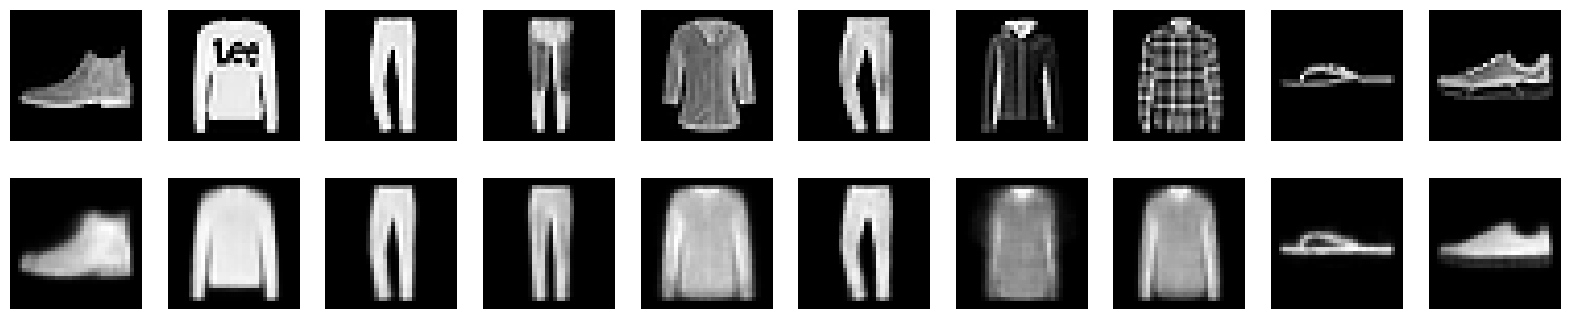

In [ ]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


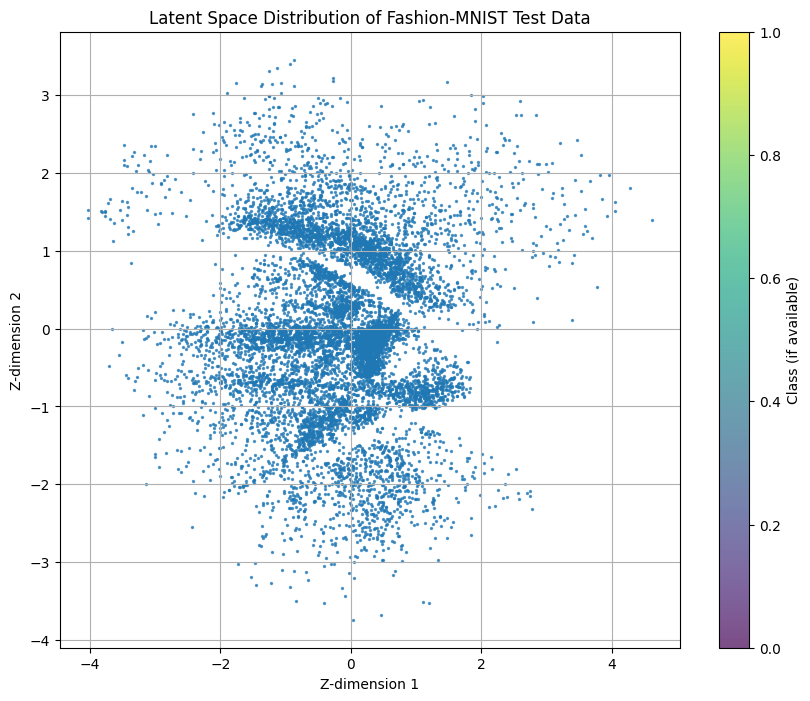

In [ ]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_means, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_means[:, 0], z_means[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)")  # Label ini akan muncul walau tanpa warna kelas
plt.grid(True)
plt.show()

In [ ]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


## Generate Latent Space Means for Test Data



In [ ]:
print("Shape of z_means:", z_means.shape)
print("First 5 elements of z_means:\n", z_means[:5])

Shape of z_means: (10000, 2)
First 5 elements of z_means:
 [[ 0.27994174  1.2640811 ]
 [ 0.2797194  -0.09385365]
 [ 1.2599643  -2.1706553 ]
 [-0.00350035 -1.9914355 ]
 [-0.6506815   0.03630771]]


## Visualize Latent Space Distribution by Class



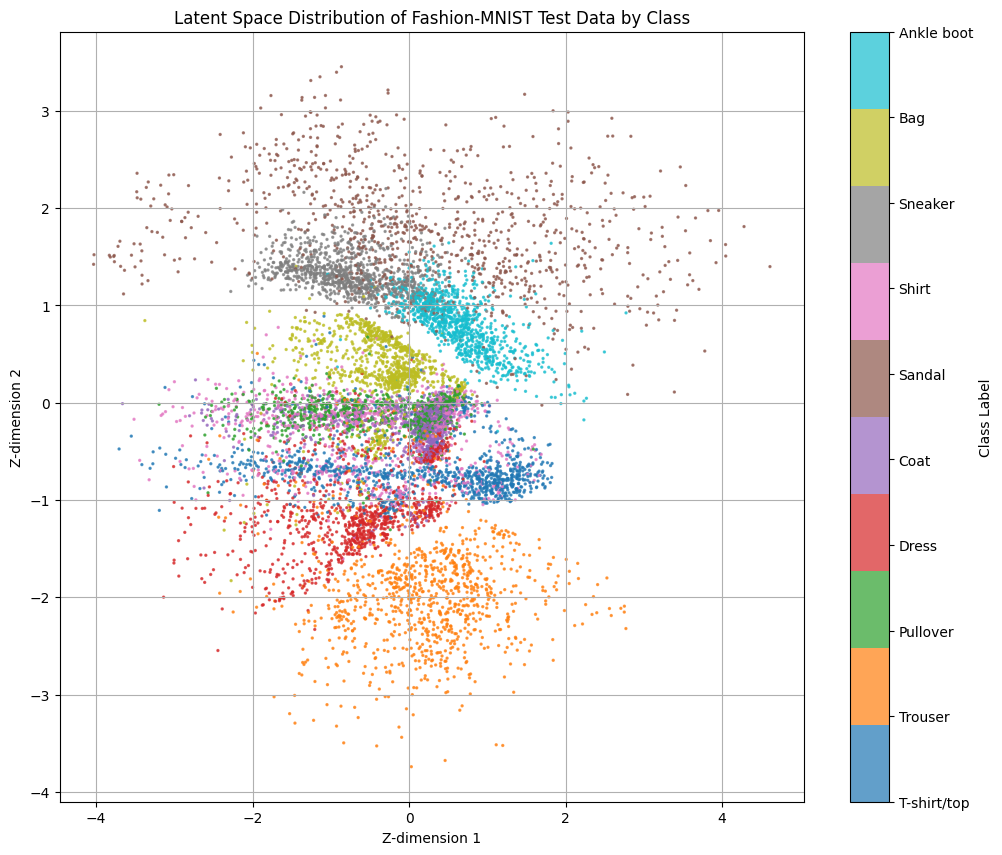

In [ ]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()

Latent space arithmetic

Interpolasi dari Index 0 ke Index 10


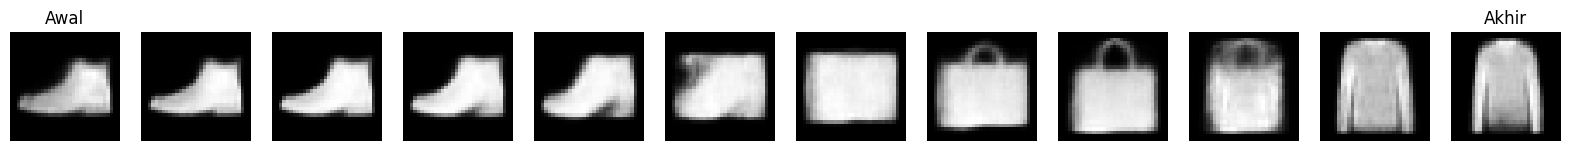

Interpolasi dari Index 100 ke Index 200


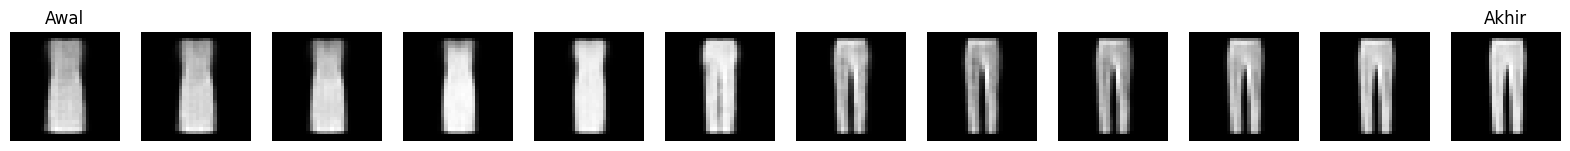

In [22]:
# -------------------------------
# 3: Latent Space Arithmetic (Interpolasi)
# -------------------------------
import matplotlib.pyplot as plt

def plot_interpolation(model, encoder, data, index1, index2, steps=10):
    """
    Melakukan interpolasi linier antara dua gambar dalam latent space
    """
    # 1. Ambil dua gambar dari data test
    img1 = data[index1:index1+1]
    img2 = data[index2:index2+1]

    # 2. Encode gambar ke latent space (ambil z_mean)
    z1, _, _ = encoder.predict(img1, verbose=0)
    z2, _, _ = encoder.predict(img2, verbose=0)

    # 3. Buat vektor interpolasi (transisi dari z1 ke z2)
    vectors = []
    alphas = np.linspace(0, 1, steps)
    for alpha in alphas:
        v = z1 * (1 - alpha) + z2 * alpha
        vectors.append(v)
    vectors = np.array(vectors).squeeze() # Shape: (steps, latent_dim)

    # 4. Decode vektor kembali ke gambar
    decoded_imgs = model.decoder.predict(vectors, verbose=0)

    # 5. Plotting
    plt.figure(figsize=(20, 4))
    print(f"Interpolasi dari Index {index1} ke Index {index2}")

    for i in range(steps):
        ax = plt.subplot(1, steps, i + 1)
        plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Awal")
        if i == steps - 1: ax.set_title("Akhir")
    plt.show()

# Cari index gambar yang berbeda kelas untuk melihat efek morphing
# Contoh: Sepatu (index 0) ke Baju (index 1) atau variasi lainnya
plot_interpolation(vae, encoder, x_test, index1=0, index2=10, steps=12)
plot_interpolation(vae, encoder, x_test, index1=100, index2=200, steps=12)

Perbandingan Rekonstruksi (VAE vs Autoencoder Biasa)

Training Standard Autoencoder...
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 250s 523ms/step - loss: 0.3911 - val_loss: 0.2666
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 522ms/step - loss: 0.2628 - val_loss: 0.2587
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 245s 522ms/step - loss: 0.2575 - val_loss: 0.2560
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 247s 526ms/step - loss: 0.2537 - val_loss: 0.2549
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 526ms/step - loss: 0.2528 - val_loss: 0.2538
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 269s 542ms/step - loss: 0.2517 - val_loss: 0.2522
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 248s 513ms/step - loss: 0.2504 - val_loss: 0.2518
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 263s 515ms/step - loss: 0.2495 - val_loss: 0.2513
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 270s 532ms/step - loss: 0.2494 - val_loss: 0.2504
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 241s 514ms/step - loss: 0.2480 - val_loss: 0.2503
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 514ms/step - loss: 0

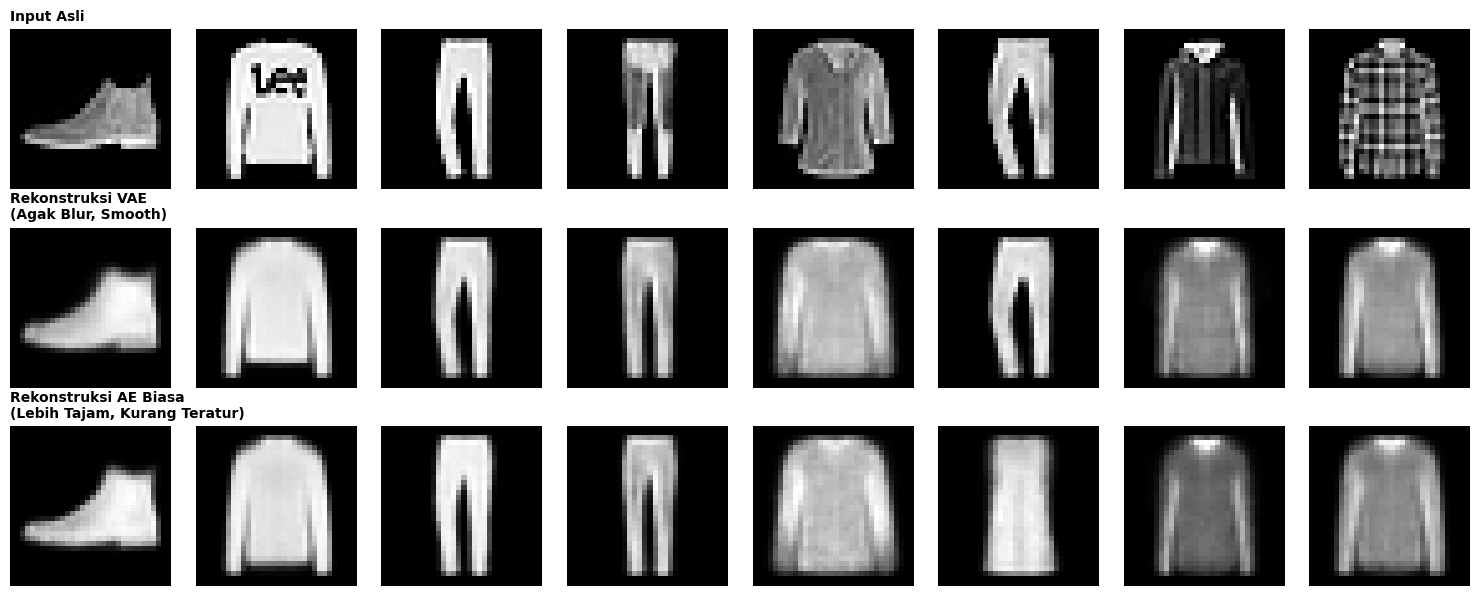

In [21]:
# -------------------------------
# 4: Perbandingan VAE dan Autoencoder Biasa (AE)
# -------------------------------

# A. Bangun Autoencoder Biasa (Standard AE)
# Kita gunakan arsitektur yang sama persis, tapi tanpa Sampling dan loss KL

# 1. Encoder AE
ae_input = layers.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(ae_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
# Perbedaan utama: Langsung ke latent vector z, tidak ada mean/log_var/sampling
ae_z = layers.Dense(latent_dim, name="ae_latent")(x)

ae_encoder = models.Model(ae_input, ae_z, name="ae_encoder")

# 2. Decoder AE (Gunakan arsitektur yang sama dengan VAE decoder sebelumnya)
# Kita bisa menggunakan kembali variabel 'decoder' yang sudah dilatih di VAE
# untuk struktur, tapi kita buat instance baru agar bobotnya fresh/kosong.
ae_decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(ae_decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
ae_decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)

ae_decoder = models.Model(ae_decoder_input, ae_decoder_output, name="ae_decoder")

# 3. Gabungkan menjadi AE Model
ae_model_input = layers.Input(shape=(32, 32, 1))
encoded_img = ae_encoder(ae_model_input)
decoded_img = ae_decoder(encoded_img)
autoencoder = models.Model(ae_model_input, decoded_img, name="autoencoder")

# 4. Compile dan Train AE
# AE biasa hanya menggunakan MSE atau Binary Crossentropy sebagai loss
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print("Training Standard Autoencoder...")
# Kita latih lebih cepat (misal 10-20 epoch) hanya untuk perbandingan
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=1)

# B. Visualisasi Perbandingan

def compare_reconstructions(vae_model, ae_model, data, n=8):
    # Prediksi VAE
    _, _, vae_recon = vae_model(data[:n])

    # Prediksi AE
    ae_recon = ae_model.predict(data[:n], verbose=0)

    plt.figure(figsize=(15, 6))
    for i in range(n):
        # Gambar Asli
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Input Asli", fontsize=10, fontweight='bold', loc='left')

        # Rekonstruksi VAE
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(vae_recon[i].numpy().squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Rekonstruksi VAE\n(Agak Blur, Smooth)", fontsize=10, fontweight='bold', loc='left')

        # Rekonstruksi AE Biasa
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_recon[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Rekonstruksi AE Biasa\n(Lebih Tajam, Kurang Teratur)", fontsize=10, fontweight='bold', loc='left')

    plt.tight_layout()
    plt.show()

# Jalankan perbandingan
compare_reconstructions(vae, autoencoder, x_test)